In [1]:
cd /kaggle/input/transformer-summarizer-ds

/kaggle/input/transformer-summarizer-ds


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import re
import pdb
import time
import utils
import torch
import textwrap
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers


wrapper = textwrap.TextWrapper(width=70)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transformer-summarizer-ds/train.json
/kaggle/input/transformer-summarizer-ds/test.json
/kaggle/input/transformer-summarizer-ds/utils.py
/kaggle/input/transformer-summarizer-ds/val.json


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import the Dataset

In [4]:
train_data, test_data = utils.get_train_test_data()

# A single example from the dataset
example_summary, example_dialogue = train_data.iloc[10]
print(f"Dialogue: \n{example_dialogue}")
print(f"\nSummary: \n{example_summary}")

Dialogue: 
Lucas: Hey! How was your day?
Demi: Hey there! 
Demi: It was pretty fine, actually, thank you!
Demi: I just got promoted! :D
Lucas: Whoa! Great news!
Lucas: Congratulations!
Lucas: Such a success has to be celebrated.
Demi: I agree! :D
Demi: Tonight at Death & Co.?
Lucas: Sure!
Lucas: See you there at 10pm?
Demi: Yeah! See you there! :D

Summary: 
Demi got promoted. She will celebrate that with Lucas at Death & Co at 10 pm.


# Preprocess the data

In [5]:
document, summary = utils.preprocess(train_data)
document_test, summary_test = utils.preprocess(test_data)

In [6]:
print(document[0])

[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]


## Concatenating summaries and docs to prepare before passing into the tokenizer

In [7]:
docs_and_summary = pd.concat([document, summary], ignore_index=True)

## Punctuation filtering

In [8]:
def apply_filters(text):
    filters = r'[!"#$%&()*+,-./:;<=>?@\\^_`{|}~\t\n]'
    if isinstance(text, str):
        preprocessed_text = re.sub(filters, ' ', text)
        
    else:
        preprocessed_text = [re.sub(filters, ' ', sentence) for sentence in text]
    return preprocessed_text

### Applying filtering on training data before tokenizing

In [9]:
filtered_docs_and_summary = apply_filters(docs_and_summary)

## Tokenizer

In [10]:
tokenizer = Tokenizer(models.WordLevel(unk_token='[UNK]'))
tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
trainer = trainers.WordLevelTrainer(vocab_size=34249, special_tokens=['[PAD]', '[UNK]'])

tokenizer.train_from_iterator(filtered_docs_and_summary, trainer)

vocabulary = tokenizer.get_vocab()
vocab_size = tokenizer.get_vocab_size() + 1
print(f'Size of vocabulary: {vocab_size}')

Size of vocabulary: 34250


In [11]:
vocabulary = sorted(vocabulary.items(), key=lambda key: key[1])
print(vocabulary[:10])

[('[PAD]', 0), ('[UNK]', 1), ('i', 2), ('the', 3), ('to', 4), ('you', 5), ('a', 6), ('[EOS]', 7), ('[SOS]', 8), ('and', 9)]


In [12]:
encoded = tokenizer.encode(apply_filters(document[0]))
print(encoded.ids)

[8, 454, 2, 3505, 1613, 30, 5, 81, 50, 619, 66, 454, 63, 220, 5, 98, 7]


In [13]:
print(apply_filters(document[0]))

[SOS] amanda  i baked  cookies  do you want some   jerry  sure   amanda  i'll bring you tomorrow     [EOS]


In [14]:
encoder_maxlen = 150
decoder_maxlen = 50

# Padding & truncating documents (outputs)
tokenizer.enable_padding(length=decoder_maxlen)
tokenizer.enable_truncation(max_length=decoder_maxlen)

targets = tokenizer.encode_batch(apply_filters(summary))

# Padding & truncating documents (inputs)
tokenizer.enable_padding(length=encoder_maxlen)
tokenizer.enable_truncation(encoder_maxlen)

inputs = tokenizer.encode_batch(apply_filters(document))

# Extracting ids only
inputs = torch.tensor([seq.ids for seq in inputs])
targets = torch.tensor([seq.ids for seq in targets])

## Dataset

In [15]:
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs, self.targets = inputs, targets
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [16]:
train_dataset = CustomDataset(inputs, targets)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Positional Encoding

In [17]:
def positional_encoding(num_positions, d_model): 
    
    position = np.arange(num_positions)[:, np.newaxis]
    k = np.arange(d_model)[np.newaxis, :]
    i = k // 2
    
    angle_rates = 1 / np.power(10000, (2 * i) / np.float32(d_model))
    angle_rads = position * angle_rates
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1:2])    
    
    pos_encoding = angle_rads[np.newaxis, ...]
    return torch.tensor(pos_encoding, dtype=torch.float32, device=device)

# Masking

In [18]:
def create_padding_mask(token_ids):
    seq = torch.logical_not(torch.eq(token_ids, 0)).float()
    return seq


def create_look_ahead_mask(sequence_length, batch_size):
    mask = torch.tril(torch.ones((1 * batch_size, sequence_length, sequence_length)))
    return mask

# Self attention

## Scaled dot product attention

In [19]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = torch.matmul(q, k.T)

    dk = torch.tensor(k.size(-1), dtype=torch.float)
    scaled_attention_logits = matmul_qk / torch.sqrt(dk)
    scaled_attention_logits = torch.unsqueeze(scaled_attention_logits, dim=0)
    
    if mask is not None:
        scaled_attention_logits += (1. - mask) * -1e9
        
    attention_weights = torch.softmax(scaled_attention_logits, dim=-1)
    
    output = torch.matmul(attention_weights, v)
    return output, attention_weights

In [20]:
# Test your function!
q = torch.tensor([[1, 1, 0, 1], [0, 1, 1, 1], [1, 0, 1, 1]]).float()
k = torch.tensor([[1, 1, 0, 1], [1, 0, 1, 1 ], [1, 1, 1, 0], [0, 0, 0, 1], [0, 1, 0, 1]]).float()
v = torch.tensor([[0, 0], [1, 0], [1, 0], [1, 1], [1, 1]]).float()
mask = torch.tensor([[[0, 1, 0, 1, 1], [1, 0, 0, 1, 1], [1, 1, 0, 1, 1]]])

ou, atw = scaled_dot_product_attention(q, k, v, mask)
ou = torch.round(ou, decimals=2)
atw = torch.round(atw, decimals=2)

print(f"Output:\n {ou}")
print(f"\nAttention weigths:\n {atw}")

Output:
 tensor([[[1.0000, 0.6200],
         [0.6200, 0.6200],
         [0.7400, 0.3100]]])

Attention weigths:
 tensor([[[0.0000, 0.3800, 0.0000, 0.2300, 0.3800],
         [0.3800, 0.0000, 0.0000, 0.2300, 0.3800],
         [0.2600, 0.4300, 0.0000, 0.1600, 0.1600]]])


# Encoder

In [21]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return nn.Sequential(
        nn.Linear(embedding_dim, fully_connected_dim, device=device),
        nn.ReLU(),
        nn.Linear(fully_connected_dim, embedding_dim, device=device)
    )

## Encoder Layer

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super().__init__()
        
        self.mha = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_rate, batch_first=True, device=device)
        self.ffn = FullyConnected(embedding_dim, fully_connected_dim)
        
        self.layernorm1 = nn.LayerNorm(embedding_dim, eps=layernorm_eps, device=device)
        self.layernorm2 = nn.LayerNorm(embedding_dim, eps=layernorm_eps, device=device)
        
        self.dropout_ffn = nn.Dropout(dropout_rate)
    
    def forward(self, x, mask):
        mha_output, _ = self.mha(x, x, x, mask)
        skip_x_attention = self.layernorm1(x + mha_output)
        
        ffn_output = self.ffn(skip_x_attention)
        ffn_output = self.dropout_ffn(ffn_output)
        encoder_layer_out = self.layernorm2(ffn_output + skip_x_attention)
        
        return encoder_layer_out

## Full Encoder

In [23]:
class Encoder(nn.Module):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
                maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super().__init__()
        
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim).to(device)
        
        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim, 
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(num_layers)]
        
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x, mask):
        seq_len = x.shape[1]

        x = self.embedding(x)
        x *= torch.sqrt(torch.tensor(self.embedding_dim)).float()
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x

# Decoder

## Decoder Layer

In [24]:
class DecoderLayer(nn.Module):
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm=1e-6):
        super().__init__()
        
        self.mha1 = nn.MultiheadAttention(embedding_dim, num_heads, dropout_rate, batch_first=True, device=device)
        self.mha2 = nn.MultiheadAttention(embedding_dim, num_heads, dropout_rate, batch_first=True, device=device)
        
        self.ffn = FullyConnected(embedding_dim, fully_connected_dim)
        
        self.layernorm1 = nn.LayerNorm(embedding_dim, layernorm, device=device)
        self.layernorm2 = nn.LayerNorm(embedding_dim, layernorm, device=device)
        self.layernorm3 = nn.LayerNorm(embedding_dim, layernorm, device=device)
        
        self.dropout_ffn = nn.Dropout(dropout_rate)
        
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, attn_mask=look_ahead_mask, average_attn_weights=False)
        Q1 = self.layernorm1(x + mult_attn_out1)
        
        mult_attn_out2, attn_weights_block2 = self.mha2(x, enc_output, enc_output, key_padding_mask=padding_mask, average_attn_weights=False)
        mult_attn_out2 = self.layernorm2(Q1 + mult_attn_out2)

        ffn_output = self.ffn(mult_attn_out2)
        ffn_output = self.dropout_ffn(ffn_output)
        out3 = self.layernorm3(ffn_output + mult_attn_out2)

        return out3, attn_weights_block1, attn_weights_block2

In [25]:
key_dim = 192
n_heads = 16

decoderLayer_test = DecoderLayer(embedding_dim=key_dim, num_heads=n_heads, fully_connected_dim=32).to(device)

q = torch.ones((1, 15, key_dim), device=device)
encoder_test_output = torch.tensor(np.random.rand(1, 7, key_dim), dtype=torch.float32, device=device)
look_ahead_mask = create_look_ahead_mask(q.shape[1], n_heads).to(device)

out, attn_w_b1, attn_w_b2 = decoderLayer_test(q, encoder_test_output, look_ahead_mask, None)

print(f"Using embedding_dim={key_dim} and num_heads={n_heads}:\n")
print(f"q has shape:{q.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder layer has shape:{out.shape}")
print(f"Att Weights Block 1 has shape:{attn_w_b1.shape}")
print(f"Att Weights Block 2 has shape:{attn_w_b2.shape}")

Using embedding_dim=192 and num_heads=16:

q has shape:torch.Size([1, 15, 192])
Output of encoder has shape:torch.Size([1, 7, 192])

Output of decoder layer has shape:torch.Size([1, 15, 192])
Att Weights Block 1 has shape:torch.Size([1, 16, 15, 15])
Att Weights Block 2 has shape:torch.Size([1, 16, 15, 7])


## Full Decoder

In [26]:
class Decoder(nn.Module):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
                maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super().__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(target_vocab_size, embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(self.embedding_dim,
                                       num_heads,
                                       fully_connected_dim,
                                       dropout_rate,
                                       layernorm_eps)
                           for _ in range(self.num_layers)]
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = x.size(1)
        attention_weights = {}
        
        x = self.embedding(x)
        x *= torch.sqrt(torch.tensor(self.embedding_dim, dtype=torch.float))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x, attention_weights_block1, attention_weights_block2 = self.dec_layers[i](x,
                                                                                       enc_output,
                                                                                       look_ahead_mask,
                                                                                       padding_mask)
            
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = attention_weights_block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = attention_weights_block2
        
        return x, attention_weights

In [27]:
# Test your function!
n_layers = 5
emb_d = 221
n_heads = 17
fully_connected_dim = 16
target_vocab_size = 300
maximum_position_encoding = 6

x = torch.tensor([[3, 2, 1, 1], [2, 1, 1, 0], [2, 1, 1, 0]], device=device)

encoder_test_output = torch.randn((3, 7, emb_d), device=device)

look_ahead_mask = create_look_ahead_mask(x.shape[1], 3 * n_heads).to(device)

decoder_test = Decoder(n_layers, emb_d, n_heads, fully_connected_dim, target_vocab_size,maximum_position_encoding).to(device)
                   
outd, att_weights = decoder_test(x, encoder_test_output, look_ahead_mask, None)

print(f"Using num_layers={n_layers}, embedding_dim={emb_d} and num_heads={n_heads}:\n")
print(f"x has shape:{x.shape}")
print(f"Output of encoder has shape:{encoder_test_output.shape}\n")

print(f"Output of decoder has shape:{outd.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=5, embedding_dim=221 and num_heads=17:

x has shape:torch.Size([3, 4])
Output of encoder has shape:torch.Size([3, 7, 221])

Output of decoder has shape:torch.Size([3, 4, 221])

Attention weights:
decoder_layer1_block1_self_att has shape:torch.Size([3, 17, 4, 4])
decoder_layer1_block2_decenc_att has shape:torch.Size([3, 17, 4, 7])
decoder_layer2_block1_self_att has shape:torch.Size([3, 17, 4, 4])
decoder_layer2_block2_decenc_att has shape:torch.Size([3, 17, 4, 7])
decoder_layer3_block1_self_att has shape:torch.Size([3, 17, 4, 4])
decoder_layer3_block2_decenc_att has shape:torch.Size([3, 17, 4, 7])
decoder_layer4_block1_self_att has shape:torch.Size([3, 17, 4, 4])
decoder_layer4_block2_decenc_att has shape:torch.Size([3, 17, 4, 7])
decoder_layer5_block1_self_att has shape:torch.Size([3, 17, 4, 4])
decoder_layer5_block2_decenc_att has shape:torch.Size([3, 17, 4, 7])


# Transformer

In [28]:
class Transformer(nn.Module):
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim,
                input_vocab_size, target_vocab_size, max_positional_encoding_input, 
                max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super().__init__()
        
        self.encoder = Encoder(num_layers, embedding_dim, num_heads,
                               fully_connected_dim, input_vocab_size,
                               max_positional_encoding_input, dropout_rate, layernorm_eps)
        
        self.decoder = Decoder(num_layers, embedding_dim, num_heads,
                               fully_connected_dim, target_vocab_size, 
                               max_positional_encoding_target,dropout_rate, layernorm_eps)
        
        self.final_layer = nn.Linear(embedding_dim, target_vocab_size)
        
    def forward(self, input_sentence, output_sentence, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(input_sentence, enc_padding_mask)
        
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, look_ahead_mask, dec_padding_mask)
        
        final_out = self.final_layer(dec_output)
        final_out = torch.transpose(final_out, 1, 2)
        
        return final_out, attention_weights

In [29]:
# Test your function!
n_layers = 3
emb_d = 221
n_heads = 17
fully_connected_dim = 8
input_vocab_size = 300
target_vocab_size = 350
max_positional_encoding_input = 12
max_positional_encoding_target = 12

transformer = Transformer(n_layers, 
    emb_d, 
    n_heads, 
    fully_connected_dim, 
    input_vocab_size, 
    target_vocab_size, 
    max_positional_encoding_input,
    max_positional_encoding_target
    ).to(device)

# 0 is the padding value
sentence_a = torch.tensor([[2, 3, 1, 3, 0, 0, 0]]).to(device)
sentence_b = torch.tensor([[1, 3, 4, 0, 0, 0, 0]]).to(device)

enc_padding_mask = create_padding_mask(sentence_a).to(device)
dec_padding_mask = create_padding_mask(sentence_a).to(device)

look_ahead_mask = create_look_ahead_mask(sentence_a.shape[1], n_heads).to(device)

test_summary, att_weights = transformer(
    sentence_a,
    sentence_b,
    enc_padding_mask,
    look_ahead_mask,
    dec_padding_mask
)

print(f"Using num_layers={n_layers}, target_vocab_size={target_vocab_size} and num_heads={n_heads}:\n")
print(f"sentence_a has shape:{sentence_a.shape}")
print(f"sentence_b has shape:{sentence_b.shape}")

print(f"\nOutput of transformer (summary) has shape:{test_summary.shape}\n")
print("Attention weights:")
for name, tensor in att_weights.items():
    print(f"{name} has shape:{tensor.shape}")

Using num_layers=3, target_vocab_size=350 and num_heads=17:

sentence_a has shape:torch.Size([1, 7])
sentence_b has shape:torch.Size([1, 7])

Output of transformer (summary) has shape:torch.Size([1, 350, 7])

Attention weights:
decoder_layer1_block1_self_att has shape:torch.Size([1, 17, 7, 7])
decoder_layer1_block2_decenc_att has shape:torch.Size([1, 17, 7, 7])
decoder_layer2_block1_self_att has shape:torch.Size([1, 17, 7, 7])
decoder_layer2_block2_decenc_att has shape:torch.Size([1, 17, 7, 7])
decoder_layer3_block1_self_att has shape:torch.Size([1, 17, 7, 7])
decoder_layer3_block2_decenc_att has shape:torch.Size([1, 17, 7, 7])


# Model initialization

In [30]:
# Define the model parameters
num_layers = 2
embedding_dim = 128
fully_connected_dim = 128
num_heads = 2
positional_encoding_length = 256

# Initialize the model
transformer = Transformer(
    num_layers, 
    embedding_dim, 
    num_heads, 
    fully_connected_dim,
    vocab_size, 
    vocab_size, 
    positional_encoding_length, 
    positional_encoding_length,
).to(device)

# Prepare for training the model

## LR scheduler

In [31]:
class CustomSchedule():
    def __init__(self, d_model, warmup_steps=4000):
        self.d_model = torch.tensor(d_model, dtype=torch.float32)
        self.warmup_steps = warmup_steps
        
    def get_lr(self, step):
        arg1 = torch.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return torch.rsqrt(self.d_model) * torch.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(embedding_dim)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.1, betas=(0.9, 0.98), eps=1e-09)

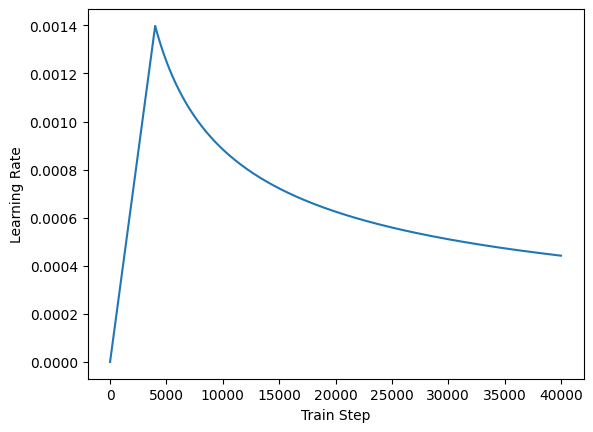

In [32]:
plt.plot(learning_rate.get_lr(torch.arange(0, 40000, dtype=torch.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

## Loss

In [33]:
loss_object = nn.CrossEntropyLoss(reduction='none')

def masked_loss(preds, ground_truth):
    mask = torch.logical_not(torch.eq(ground_truth, 0))
    loss_ = loss_object(preds, ground_truth)
    
    loss_ *= mask
    
    return torch.sum(loss_) / torch.sum(mask)

# Summarization

## Next word

In [34]:
def next_word(model, encoder_input, output):
    enc_padding_mask = create_padding_mask(encoder_input).to(device)
    look_ahead_mask = create_look_ahead_mask(output.shape[-1], num_heads).to(device)
    dec_padding_mask = create_padding_mask(encoder_input).to(device)    
    
    predictions, attention_weights = model(
        encoder_input,
        output,
        enc_padding_mask,
        look_ahead_mask,
        dec_padding_mask)
    
    predictions = predictions[:, :, -1:]
    predicted_id = torch.argmax(predictions, axis=1)
    
    return predicted_id

In [35]:
input_document = tokenizer.encode("a random sentence")
encoder_input = torch.unsqueeze(torch.tensor(input_document.ids), 0).to(device)

output = torch.tensor(tokenizer.token_to_id('[SOS]'))
output = torch.reshape(output, (1,1)).to(device)

# predict the next word with your function
predicted_token = next_word(transformer, encoder_input, output)
print(f"Predicted token: {predicted_token}")

predicted_word = tokenizer.decode(predicted_token[0].cpu().numpy())
print(f"Predicted word: {predicted_word}")

Predicted token: tensor([[1178]], device='cuda:0')
Predicted word: needed


In [36]:
def summarize(model, input_document):
    input_document = tokenizer.encode(input_document)
    encoder_input = torch.unsqueeze(torch.tensor(input_document.ids), 0).to(device)
    
    output = torch.tensor(tokenizer.token_to_id('[SOS]')).to(device)
    output = torch.reshape(output, (1,1))
    
    for i in range(decoder_maxlen):
        predicted_id = next_word(model, encoder_input, output)
        output = torch.cat((output, predicted_id), dim=-1)
        
        if predicted_id == tokenizer.token_to_id('[EOS]'):
            break
            
    return tokenizer.decode(output[0].cpu().numpy())

In [37]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
summarize(transformer, document[training_set_example])

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:


"[SOS] piece potatoes subtitles workmates digestive hand's aight settles joleeeeeeeeeeene nationalities desktop peanuts timers inches cola's shhhh minefield atkison peg sheck unpacked seriosuly caramel trans gail lolas substantial edric defensive baout called rosa's closest hale 😕 deliveroo stepped cows niece's bulk otz nutrition competitions remember viv's gretha's 72 pamela's quits mads"

# Training the model

In [38]:
test_example = 0
true_summary = summary_test[test_example]
true_document = document_test[test_example]
epoch_losses = []

epochs = 20

for epoch in range(epochs):
    running_loss = 0.0
    transformer.train()
    
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        tar_inp = targets[:, :-1].to(device)
        tar_real = targets[:, 1:].to(device)
        
        #Masks
        enc_padding_mask = create_padding_mask(inputs).to(device)
        look_ahead_mask = create_look_ahead_mask(tar_inp.shape[1], len(inputs) * num_heads).to(device)
        dec_padding_mask = create_padding_mask(inputs).to(device)
        
        optimizer.zero_grad()
        predictions, _ = transformer(
            inputs, tar_inp, enc_padding_mask,
            look_ahead_mask, dec_padding_mask
        )
        
        loss = masked_loss(predictions.to(device), tar_real)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i + 1 == len(train_loader):
            epoch_losses.append(running_loss)
        
        if i % 20 == 19:
            print(f"[epoch: {epoch}, batch: {i+1}] loss: {running_loss:.4f}")
            running_loss = 0
        
    print(f'Epoch {epoch+1}, Loss {epoch_losses[-1]}')
    print('Example summarization on the test set:\n')
    print('True summarization:')
    print(f'{true_summary}\n')
    print('Predicted summarization:')
    print(f'{summarize(transformer, true_document)}\n')

[epoch: 0, batch: 20] loss: 209.1487
[epoch: 0, batch: 40] loss: 214.2442
[epoch: 0, batch: 60] loss: 215.7994
[epoch: 0, batch: 80] loss: 217.6207
[epoch: 0, batch: 100] loss: 221.3605
[epoch: 0, batch: 120] loss: 222.3552
[epoch: 0, batch: 140] loss: 224.8007
[epoch: 0, batch: 160] loss: 223.5487
[epoch: 0, batch: 180] loss: 223.6606
[epoch: 0, batch: 200] loss: 224.6549
[epoch: 0, batch: 220] loss: 222.4231
Epoch 1, Loss 122.30789756774902
Example summarization on the test set:

True summarization:
[SOS] hannah needs betty's number but amanda doesn't have it. she needs to contact larry. [EOS]

Predicted summarization:
[SOS] stanley's down double number to celebrate barry will be late at 5 per hour jay will be late fifties [EOS]

[epoch: 1, batch: 20] loss: 201.4353
[epoch: 1, batch: 40] loss: 205.0669
[epoch: 1, batch: 60] loss: 208.4098
[epoch: 1, batch: 80] loss: 208.7284
[epoch: 1, batch: 100] loss: 208.3368
[epoch: 1, batch: 120] loss: 214.1294
[epoch: 1, batch: 140] loss: 213.1

Text(0.5, 0, 'Epoch')

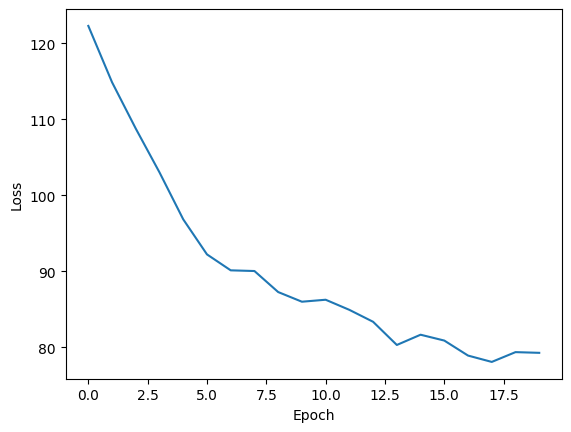

In [39]:
plt.plot(epoch_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Summarize some sentences

In [40]:
training_set_example = 0

# Check a summary of a document from the training set
print('Training set example:')
print(document[training_set_example])
print('\nHuman written summary:')
print(summary[training_set_example])
print('\nModel written summary:')
print(summarize(transformer, document[training_set_example]))

Training set example:
[SOS] amanda: i baked  cookies. do you want some?  jerry: sure!  amanda: i'll bring you tomorrow :-) [EOS]

Human written summary:
[SOS] amanda baked cookies and will bring jerry some tomorrow. [EOS]

Model written summary:
[SOS] marry and iris can be there were good idea it on a new house [EOS]


In [41]:
test_set_example = 3

# Check a summary of a document from the test set
print('Test set example:')
print(document_test[test_set_example])
print('\nHuman written summary:')
print(summary_test[test_set_example])
print('\nModel written summary:')
print(summarize(transformer, document_test[test_set_example]))

Test set example:
[SOS] will: hey babe, what do you want for dinner tonight?  emma:  gah, don't even worry about it tonight  will: what do you mean? everything ok?  emma: not really, but it's ok, don't worry about cooking though, i'm not hungry  will: well what time will you be home?  emma: soon, hopefully  will: you sure? maybe you want me to pick you up?  emma: no no it's alright. i'll be home soon, i'll tell you when i get home.   will: alright, love you.   emma: love you too.  [EOS]

Human written summary:
[SOS] emma will be home soon and she will let will know. [EOS]

Model written summary:
[SOS] fernandez tall juventus and fernandez put helga has just touching memorised hiring spotify audrey doesn't want cure and ella want to make it and ella will drop by the whole week can edit it was busy and ella suggests mr harris even if it for her exam and marcus will
